In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from numpy.random import random


## Load and Preprocessing data

In [2]:
df = pd.read_csv("data/compas_data/compas-scores-two-years.csv")
print(len(df))
df.head()

7214


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [3]:
# Filtering 

ndf = df[(df.days_b_screening_arrest <= 30)
            & (df.days_b_screening_arrest >= -30)
            & (df.is_recid != -1)
            & (df.c_charge_degree != 'O')
            & (df.score_text != 'N/A')
            ]
ndf.head()


,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,1,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,2,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1


Calculate length of stay based on time jail-in and jail-out. 

Higher COMPAS scores are slightly correlated with a longer length of stay.

In [4]:
cols = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 
                    'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 
                    'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']
ndf = ndf[cols]
ndf["length_of_stay"] = pd.to_datetime(ndf["c_jail_out"])- pd.to_datetime(ndf["c_jail_in"])
ndf.length_of_stay = ndf.length_of_stay.astype('timedelta64[h]') # Convert to hours

print("Correlation btw length of stay and decile score", ndf["decile_score"].corr(ndf["length_of_stay"]))

Correlation btw length of stay and decile score 0.2074107615030343


Notice some error within the decile score. 

In [43]:
ndf[['score_text', 'decile_score', 'two_year_recid']].head(20)
ratio_miss = len(ndf[( (ndf['score_text'] == "High") | (ndf["score_text"] == "Medium") ) & 
                 (ndf["two_year_recid"] == 0) ])/ len(ndf)
print("score error ratio =", ratio_miss*100)

score error ratio = 16.493843162670125


Make sure there are no NaN values

In [6]:
# There are no NaN values. Good
ndf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6172 entries, 0 to 7213
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      6172 non-null   int64  
 1   c_charge_degree          6172 non-null   object 
 2   race                     6172 non-null   object 
 3   age_cat                  6172 non-null   object 
 4   score_text               6172 non-null   object 
 5   sex                      6172 non-null   object 
 6   priors_count             6172 non-null   int64  
 7   days_b_screening_arrest  6172 non-null   float64
 8   decile_score             6172 non-null   int64  
 9   is_recid                 6172 non-null   int64  
 10  two_year_recid           6172 non-null   int64  
 11  c_jail_in                6172 non-null   object 
 12  c_jail_out               6172 non-null   object 
 13  length_of_stay           6172 non-null   float64
dtypes: float64(2), int64(5),

## EDA

25-45 is the most frequent range of age.

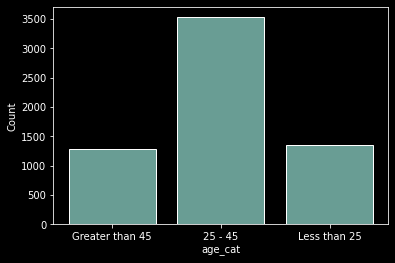

25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: age_cat, dtype: int64

In [7]:
ax = sns.histplot(data=ndf["age_cat"], discrete=True, shrink=0.8)
plt.show()

ndf["age_cat"].value_counts()

African-American people accounts for a large proportion in terms of race.

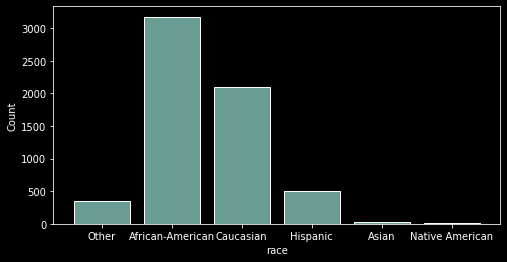

African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: race, dtype: int64

In [8]:
plt.figure(figsize=(8,4)) # this creates a figure 8 inch wide, 4 inch high
sns.histplot(data=ndf["race"], discrete=True, shrink=0.8)
plt.show()

ndf["race"].value_counts()


In [9]:
print("Black defendants: %.2f%%" %            (3175 / 6172 * 100))
print("White defendants: %.2f%%" %            (2103 / 6172 * 100))
print("Hispanic defendants: %.2f%%" %         (509  / 6172 * 100))
print("Asian defendants: %.2f%%" %            (31   / 6172 * 100))
print("Native American defendants: %.2f%%" %  (11   / 6172 * 100))

Black defendants: 51.44%
White defendants: 34.07%
Hispanic defendants: 8.25%
Asian defendants: 0.50%
Native American defendants: 0.18%


In [10]:
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100))
ndf["sex"].value_counts()


Men: 80.96%
Women: 19.04%


Male      4997
Female    1175
Name: sex, dtype: int64

In [11]:
c = len(ndf[ndf["two_year_recid"] == 1]) / len(ndf) * 100
print(f"Recidivism rate  {round(c,2)} %")

Recidivism rate  45.51 %


In [12]:
ndf["decile_score"].unique()

array([ 1,  3,  4,  6, 10,  5,  9,  2,  7,  8])

There is a clear downward trend in the decile scores as those scores increase for white defendants.

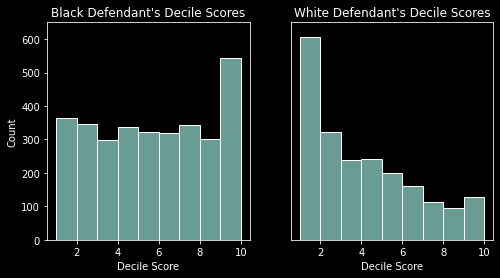

In [13]:
pblack = ndf[ndf["race"] == "African-American"]
pwhite = ndf[ndf["race"] == "Caucasian"]
fig, ax = plt.subplots(1,2, figsize=(8,4))
f1 = sns.histplot(pblack, x="decile_score", discrete=False, binwidth=1, ax=ax[0])
f1.set_xlabel("Decile Score")
f1.set(ylim=(0,650))
f1.set_title("Black Defendant's Decile Scores")

f2 = sns.histplot(pwhite, x="decile_score", discrete=False, binwidth=1, ax=ax[1])
f2.set_xlabel("Decile Score")
f2.set_yticks([])
f2.set_ylabel("")
f2.set(ylim=(0,650))
f2.set_title("White Defendant's Decile Scores")
plt.show()

In [14]:
pd.crosstab(ndf["decile_score"], ndf["race"])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


### Racial Bias in Compas
After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [15]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs', max_iter=1000)


In [16]:
df_crime = pd.get_dummies(ndf['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(ndf['age_cat'],prefix='age')
df_race = pd.get_dummies(ndf['race'],prefix='race')
df_gender = pd.get_dummies(ndf['sex'] != "Male", prefix='sex',drop_first=True)
df_score = pd.get_dummies(ndf['score_text'] != 'Low',prefix='score_factor',drop_first=True)

df_lr = pd.concat([df_crime, df_age, df_race, df_gender,
                    ndf["priors_count"], ndf["two_year_recid"]], axis=1)

lr.fit(df_lr, df_score.values.ravel())

LogisticRegression(max_iter=1000)

In [17]:
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                ["sex_Female"],
                ['priors_count'],
                ['two_year_recid']
               ])


In [18]:
assert len(cols) == len(lr.coef_[0])
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.548 (Intercept)
-0.310 crimefactor_M
0.014 age_25 - 45
-1.331 age_Greater than 45
1.316 age_Less than 25
0.488 race_African-American
-0.199 race_Asian
0.011 race_Caucasian
-0.411 race_Hispanic
0.905 race_Native American
-0.795 race_Other
0.219 sex_Female
0.268 priors_count
0.683 two_year_recid


Black defendants are 45% more likely than white defendants to receive a higher score

In [19]:
control = np.exp(-1.548) / (1 + np.exp(-1.548))
black_odds = np.exp(0.488) / (1 - control + (control * np.exp(0.488)))

print('Black defendants: %.4f' % black_odds)

Black defendants: 1.4672


Women are 19.3% more likely than men to get a higher score.

In [20]:
female_odds = np.exp(0.219) / (1 - control + (control * np.exp(0.219)))
print("Female defendants: %.4f" % female_odds)

Female defendants: 1.1936


Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

In [21]:
under25_odds = np.exp(1.316) / (1 - control + (control * np.exp(1.316)))
print("Under 25 defendents: %.4f" % under25_odds)

Under 25 defendents: 2.5218


### Feature Engineering

In [22]:
if not (ndf['is_recid'].equals(ndf['two_year_recid'])):
    not_eq = ndf[ndf['is_recid'] != ndf['two_year_recid']]
    print(len(not_eq) / len(ndf)) # Why is this happening ? 


0.02932598833441348


In [23]:
ndf.columns

Index(['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex',
       'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid',
       'two_year_recid', 'c_jail_in', 'c_jail_out', 'length_of_stay'],
      dtype='object')

In [24]:

categorical = ["race", "sex", "c_charge_degree"]

feature_to_keep = [ 'age',
                    'c_charge_degree',
                    'race',
                    'sex',
                    'priors_count',
                    'days_b_screening_arrest',
                    'two_year_recid',
                    'length_of_stay'
                    ]
nndf = ndf[feature_to_keep]

# Setting feature vector and target vector.
X = nndf.drop(["two_year_recid"], axis=1)
y  = nndf['two_year_recid']

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [25]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encoded categorical variabels
for feat in categorical:
    le = LabelEncoder()
    X_train[feat] = le.fit_transform(X_train[feat])
    X_test[feat] = le.transform(X_test[feat])

# Feature Scalling

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)

In [26]:
X_train.head()

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,length_of_stay
0,1.228043,1.351749,0.541924,0.487670,-0.472233,-4.753046,-0.308548
1,0.463098,1.351749,-0.852010,-2.050566,0.159882,0.140089,-0.301340
2,-1.236778,1.351749,0.541924,0.487670,-0.682938,0.140089,-0.309449
3,-0.726815,-0.739782,0.541924,0.487670,-0.472233,0.140089,-0.311251
4,1.143049,-0.739782,0.541924,0.487670,-0.472233,0.140089,2.462003


In [27]:
#  Logistic Regression model with all features

from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import accuracy_score

lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

print(f"Logistic Regression acc score with all the features {accuracy_score(y_test, y_pred)}")

Logistic Regression acc score with all the features 0.6792656587473002


I do the PCA to see if we can drop any features but seems like all features are required.

In [28]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)

cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.argmax(cumsum >= 0.90) + 1
print('The number of dimensions required to preserve 90% of variance is',dim)

pca.explained_variance_ratio_


The number of dimensions required to preserve 90% of variance is 6


array([0.21499654, 0.16457643, 0.14292459, 0.13587826, 0.13224767,
       0.11703297, 0.09234355])

Let's try to drop the last features with the least value of explained_variance_ratio

In [29]:

X_trial = nndf.drop(['length_of_stay', 'two_year_recid'], axis=1)
y_trial  = nndf['two_year_recid']

X_train, X_test, y_train, y_test = train_test_split(X_trial, y_trial, test_size = 0.3, random_state = 0)

for feature in categorical:
        le = LabelEncoder()
        X_train[feature] = le.fit_transform(X_train[feature])
        X_test[feature] = le.transform(X_test[feature])


X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_trial.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns = X_trial.columns)

lg = LogisticRegression()
lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)

print(f"Logistic Regression acc score with the first 6 features {accuracy_score(y_test, y_pred)}")



Logistic Regression acc score with the first 6 features 0.67170626349892


The accuracy seems to not improve and got worse. Therefore, we might should keep all the features

## Save npy file for X, y

In [30]:
# Setting feature vector and target vector.
X = nndf.drop(["two_year_recid"], axis=1)
y  = nndf['two_year_recid']

In [31]:
X.head()

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,length_of_stay
0,69,F,Other,Male,0,-1.0,23.0
1,34,F,African-American,Male,0,-1.0,241.0
2,24,F,African-American,Male,4,-1.0,26.0
5,44,M,Other,Male,0,0.0,31.0
6,41,F,Caucasian,Male,14,-1.0,151.0


In [32]:
pd.options.mode.chained_assignment = None

# Change target y from 0 to -1
y[y == 0] = -1
y

0      -1
1       1
2       1
5      -1
6       1
       ..
7209   -1
7210   -1
7211   -1
7212   -1
7213    1
Name: two_year_recid, Length: 6172, dtype: int64

In [33]:
pd.options.mode.chained_assignment = None

# Change race to only 2 groups 'Caucasian' and 'Non-Caucasian'
X.loc[X.race != 'Caucasian', 'race'] = 'Non-Caucasian'
X.head()

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,length_of_stay
0,69,F,Non-Caucasian,Male,0,-1.0,23.0
1,34,F,Non-Caucasian,Male,0,-1.0,241.0
2,24,F,Non-Caucasian,Male,4,-1.0,26.0
5,44,M,Non-Caucasian,Male,0,0.0,31.0
6,41,F,Caucasian,Male,14,-1.0,151.0


In [34]:
categorical =  ['c_charge_degree', 'race', 'sex']
for feat in categorical:
    le = LabelEncoder()
    X[feat] = le.fit_transform(X[feat])

le = LabelEncoder()
y = le.fit_transform(y)

# Feature Scalling

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

X_train_save = X_train.to_numpy()
y[y == 0] = -1
y_train_save = y
sensitive_feat = X.race.to_numpy() # Choose race as sensitive feature
s1_train = sensitive_feat


np.save("data/compas_data/XS_compas.npy", X_train_save)
np.save("data/compas_data/y_compas.npy", y_train_save)
np.save("data/compas_data/s_compas.npy", s1_train)

In [35]:
X_train_save.shape, y_train_save.shape, s1_train.shape

((6172, 7), (6172,), (6172,))

In [36]:
X_train

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,length_of_stay
0,2.938237,-0.744755,0.718912,0.484913,-0.684413,0.145601,-0.302738
1,-0.045568,-0.744755,0.718912,0.484913,-0.684413,0.145601,-0.108157
2,-0.898084,-0.744755,0.718912,0.484913,0.158866,0.145601,-0.300060
3,0.806948,1.342724,0.718912,0.484913,-0.684413,0.342285,-0.295597
4,0.551193,-0.744755,-1.390991,0.484913,2.267065,0.145601,-0.188489
...,...,...,...,...,...,...,...
6167,-0.983335,-0.744755,0.718912,0.484913,-0.684413,0.145601,-0.283101
6168,-0.983335,-0.744755,0.718912,0.484913,-0.684413,0.145601,-0.283994
6169,1.915218,-0.744755,0.718912,0.484913,-0.684413,0.145601,-0.300060
6170,-0.130819,1.342724,0.718912,-2.062224,-0.051954,0.145601,-0.298275


In [37]:
print(set(s1_train))

print(set(y_train_save))

{0, 1}
{1, -1}


## Poisoning data with label flipping

For generation of poisoned data, we poison
about 10% of the training data by flipping the labels of examples
that belong to a specific z attribute (for this experiment z
= 1) so as to maximize the accuracy performance degradation

In [38]:
target_idx = X.index[ X['race'] == 1].tolist
boolArr = (X['race'] == 1)
y_poison = np.where((random(len(X)) > .85) & (boolArr), -y, y)
print(f"Proportion of label flipping = {100* sum(y_poison != y) / len(y)} %")

Proportion of label flipping = 9.753726506804925 %


In [39]:
# Save y_poison

np.save("data/compas_data/y_compas_poi.npy", y_poison)

In [40]:
corr_matrix = X_train.corr().abs()
corr_matrix.head()

,age,c_charge_degree,race,sex,priors_count,days_b_screening_arrest,length_of_stay
age,1.000000,0.101177,0.181182,0.008407,0.119773,0.068926,0.011775
c_charge_degree,0.101177,1.000000,0.077574,0.061848,0.145433,0.008043,0.109523
race,0.181182,0.077574,1.000000,0.071087,0.145093,0.071754,0.043683
sex,0.008407,0.061848,0.071087,1.000000,0.118722,0.030453,0.057005
priors_count,0.119773,0.145433,0.145093,0.118722,1.000000,0.021350,0.188967
